# Aillio Bullet Roast Data Analysis

In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import statsmodels.api as sm

import dump_roasts

In [113]:
roast_samples_fields = [
    'beanDerivative',
    'beanTemperature',
    'drumTemperature',
]

controls = {
    0: 'power',
    1: 'fan',
    2: 'drum',
}

sample_drop_factor = 2
smooth_temp_span = 7
smooth_rate_fraction = 0.1
def set_roast_samples_controls(roast_samples, actions):
    for control_type in controls.values():
        roast_samples[control_type] = None

    control_values = {}
    for action in actions:
        control_name = controls.get(action['ctrlType'], None)
        if control_name is None:
            continue
        
        if control_name not in control_values:
            control_values[control_name] = (0, action['value'])
        else:
            prior_index, prior_value = control_values[control_name]
            control_loc = roast_samples.columns.get_loc(control_name)
            roast_samples.iloc[prior_index:action['index'], control_loc] = prior_value
            control_values[control_name] = (action['index'], action['value'])

    for control_name, (index, value) in control_values.items():
        control_loc = roast_samples.columns.get_loc(control_name)
        roast_samples.iloc[index:, control_loc] = value


def create_roast_samples(roast_json, roast):
    roast_samples_columns = {f:roast_json[f] for f in roast_samples_fields}
    roast_samples_undropped = pd.DataFrame.from_dict(roast_samples_columns)
    roast_samples = roast_samples_undropped.iloc[::sample_drop_factor,:].reset_index().copy()
    sample_period = sample_drop_factor / roast['sampleRate']
    time = pd.Series([i * sample_period for i in range(0, len(roast_samples))])
    roast_samples['time'] = time
    roast_samples['uid'] = roast['uid']
    roast_samples['smoothBeanTemperature'] = roast_samples['beanTemperature'].ewm(span=smooth_temp_span).mean()
    roast_samples['smoothDrumTemperature'] = roast_samples['drumTemperature'].ewm(span=smooth_temp_span).mean()
    #roast_samples['smoothDrumDerivative'] = (roast_samples['drumTemperature'].diff() * 60 / sample_period).ewm(span=50).mean()
    roast_samples['rawBeanDerivative'] = (roast_samples['beanTemperature'].diff() * 60 * sample_drop_factor / sample_period).values
    roast_samples['rawDrumDerivative'] = (roast_samples['drumTemperature'].diff() * 60 * sample_drop_factor / sample_period).values
    x = roast_samples['time'].values
    roast_samples['smoothBeanDerivative'] = pd.Series(sm.nonparametric.lowess(roast_samples['rawBeanDerivative'], x, frac=smooth_rate_fraction)[:,1])
    roast_samples['smoothDrumDerivative'] = pd.Series(sm.nonparametric.lowess(roast_samples['rawDrumDerivative'], x, frac=smooth_rate_fraction)[:,1])
    #roast_samples['smoothBeanDerivative'] = (roast_samples['smoothBeanTemperature'].diff() * 60 * sample_drop_factor / sample_period).ewm(span=smooth_temp_span).mean()
    #roast_samples['smoothDrumDerivative'] = (roast_samples['smoothDrumTemperature'].diff() * 60 * sample_drop_factor / sample_period).values

    set_roast_samples_controls(roast_samples, roast_json['actions']['actionTimeList'])

    return roast_samples

    
def load_roasts(roast_dirname):
    roasts = []
    roasts_samples = []

    for roast_filename in os.listdir(roast_dirname):
        roast_pathname = os.path.join(roast_dirname, roast_filename)
        #print(f'loading {roast_pathname}')
        with open(roast_pathname, 'r', encoding='utf-8') as roast_file:
            roast_json = json.load(roast_file)

            roast = dump_roasts.create_roast(roast_json)
            roasts.append(roast)

            roast_samples = create_roast_samples(roast_json, roast)
            roasts_samples.append(roast_samples)
    
    all_roasts = pd.DataFrame(roasts).sort_values('dateTime').reset_index(drop=True)
    all_roasts['backToBack'] = all_roasts['roastNumber'] == all_roasts['roastNumber'].shift(1)

    all_roasts_samples = pd.concat(roasts_samples, ignore_index=True)
    return all_roasts, all_roasts_samples

roast_path = os.path.join(os.path.expanduser("~"), "Library/Application Support/roast-time/roasts")
roasts, roasts_samples = load_roasts(roast_path)
roast_filters = [
    roasts['ambient'].notna(),
    roasts['humidity'].notna(),
    roasts['firmware'] >= 540,
    roasts['weightGreen'] > 0,
    roasts['weightRoasted'] > 0,
    roasts['indexYellowingStart'] > 0,
    roasts['indexFirstCrackStart'] > 0,
    roasts['drumChargeTemperature'] > 200,
]

roasts_filter = True
for roast_filter in roast_filters:
    roasts_filter &= roast_filter
roasts = roasts[roasts_filter].reset_index(drop=True)

#with pd.option_context("display.min_rows", None, "display.max_rows", 20, "display.max_columns", 40):
#    display(roasts)
    
feature_columns = ['ambient', 'humidity', 'weightGreen', 'drumChargeTemperature', 'beanChargeTemperature']
roasts_samples = pd.merge(roasts, roasts_samples, how='left', on='uid')
#with pd.option_context('display.max_rows', 100, 'display.max_columns', 40):
#    display(roasts_samples)

print('OK')

OK


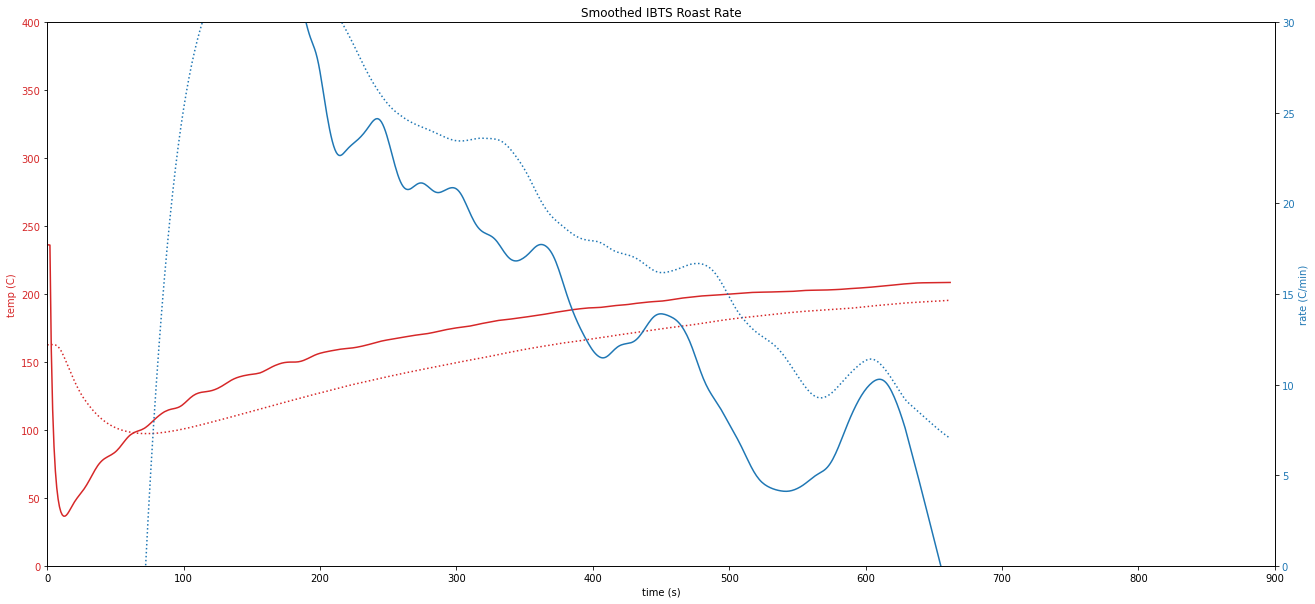

OK


In [114]:
roast_id = 'b9FYUbtgphh1S5ppmO1ae'
#roast_id = 'de53658a-7a91-410e-973f-7555e693876e'
roast_samples = roasts_samples[roasts_samples['uid'] == roast_id]

#with pd.option_context("display.min_rows", None, "display.max_rows", 2000, "display.max_columns", 40):
#    display(roast_samples[['time', 'sampleRate', 'beanTemperature', 'drumTemperature', 'smoothDrumTemperature', 'rawDrumDerivative', 'smoothDrumDerivative']])

fig, ax_temp = plt.subplots(figsize=(22, 10))

ax_temp.set_title('Smoothed IBTS Roast Rate')

color_temp = 'tab:red'
ax_temp.set_xlabel('time (s)')
ax_temp.set_xlim((0, 900))
ax_temp.set_ylabel('temp (C)', color=color_temp)
ax_temp.set_ylim((0, 400))
ax_temp.plot(roast_samples['time'], roast_samples['smoothDrumTemperature'], color=color_temp)
ax_temp.plot(roast_samples['time'], roast_samples['smoothBeanTemperature'], color=color_temp, linestyle=':')
ax_temp.tick_params(axis='y', labelcolor=color_temp)

ax_rate = ax_temp.twinx()
color_rate = 'tab:blue'
ax_rate.set_ylabel('rate (C/min)', color=color_rate)
ax_rate.set_ylim((0, 30))
ax_rate.plot(roast_samples['time'], roast_samples['smoothDrumDerivative'], color=color_rate)
ax_rate.plot(roast_samples['time'], roast_samples['smoothBeanDerivative'], color=color_rate, linestyle=':')
ax_rate.tick_params(axis='y', labelcolor=color_rate)

plt.show()
print('OK')

## IBTS-Probe Temperature Difference vs Ambient Temperature

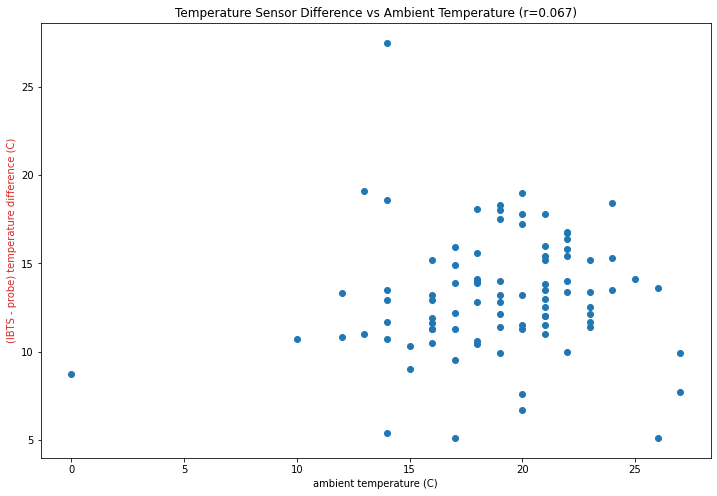

In [81]:
roasts['delta'] = roasts['drumDropTemperature'] - roasts['beanDropTemperature']
#with pd.option_context("display.min_rows", None, "display.max_rows", 100, "display.max_columns", 40):
#    display(roasts[['ambient', 'delta']])

temperature_corr = roasts['ambient'].astype('float64').corr(roasts['delta'].astype('float64'))

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title(f'Temperature Sensor Difference vs Ambient Temperature (r={temperature_corr:.2})')
ax.set_xlabel('ambient temperature (C)')
ax.set_ylabel('(IBTS - probe) temperature difference (C)', color=color_temp)
plt.scatter(roasts['ambient'], roasts['delta'])
plt.show()

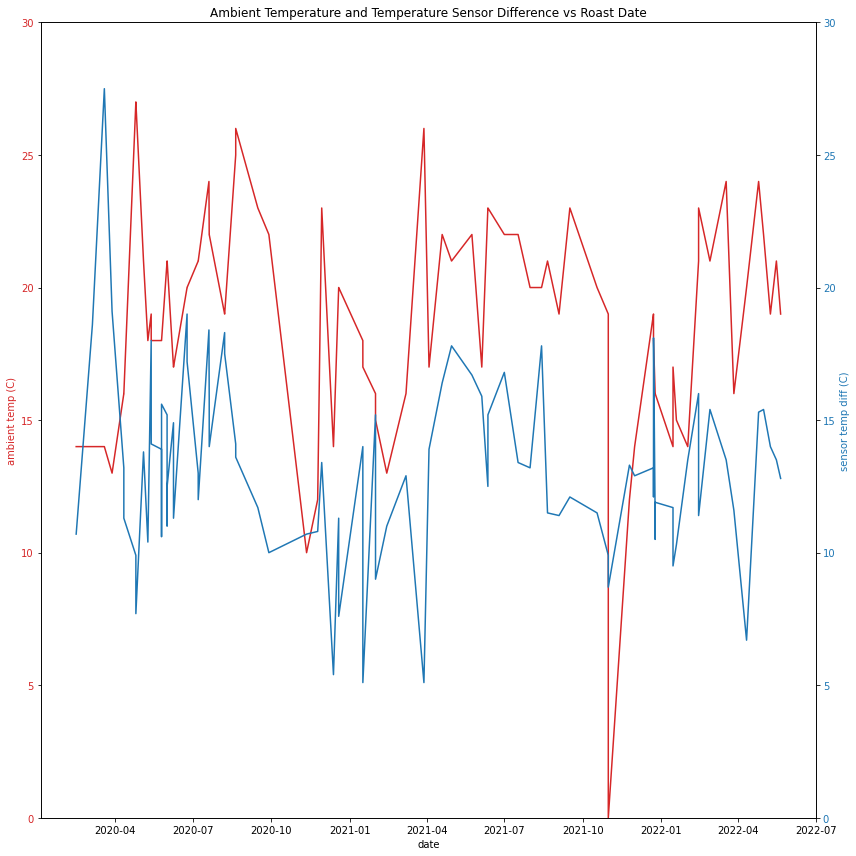

OK


In [5]:
roast_dates = pd.to_datetime(roasts['dateTime'],unit='ms')

fig, ax_temp = plt.subplots(figsize=(12, 12))
ax_temp.set_title(f'Ambient Temperature and Temperature Sensor Difference vs Roast Date')

color_ambient = 'tab:red'
ax_temp.set_xlabel('date')
ax_temp.set_ylabel('ambient temp (C)', color=color_ambient)
ax_temp.set_ylim((0, 30))
ax_temp.plot(roast_dates, roasts['ambient'], color=color_ambient)
ax_temp.tick_params(axis='y', labelcolor=color_ambient)

ax_rate = ax_temp.twinx()
color_delta = 'tab:blue'
ax_rate.set_ylabel('sensor temp diff (C)', color=color_delta)
ax_rate.set_ylim((0, 30))
ax_rate.plot(roast_dates, roasts['delta'], color=color_delta)
ax_rate.tick_params(axis='y', labelcolor=color_delta)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print('OK')